# Import the modules

In [3]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import shutil
import os
from matplotlib import pyplot as plt
plt.style.use('seaborn')
from matplotlib import image as img

%matplotlib inline
LOCAL = not 'CLOUDSDK_CONFIG' in os.environ

if not LOCAL:
  
  from google.colab import files, drive, output

2.6.0


## Download the Pokemon dataset
We will first download the archive of the dataset and then unzip it. The image dataset are directly re-used from PyImageSearch https://www.pyimagesearch.com/2018/04/16/keras-and-convolutional-neural-networks-cnns. The blog post has some great discussion on the Convolutional Neural Network (CNN). Do take a look when you have time.

In [ ]:
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1nZisCOxpI22lXU2iBbv-x-uFVEzBKIll' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1nZisCOxpI22lXU2iBbv-x-uFVEzBKIll" -O dataset.zip && rm -rf /tmp/cookies.txt
#!unzip -q dataset.zip
#!ls

In [ ]:
#ls dataset/

## Building Model
Here we will build our Convolutional Neural Network (CNN) using Keras APIs and TensorFlow backend.

### Plot some images

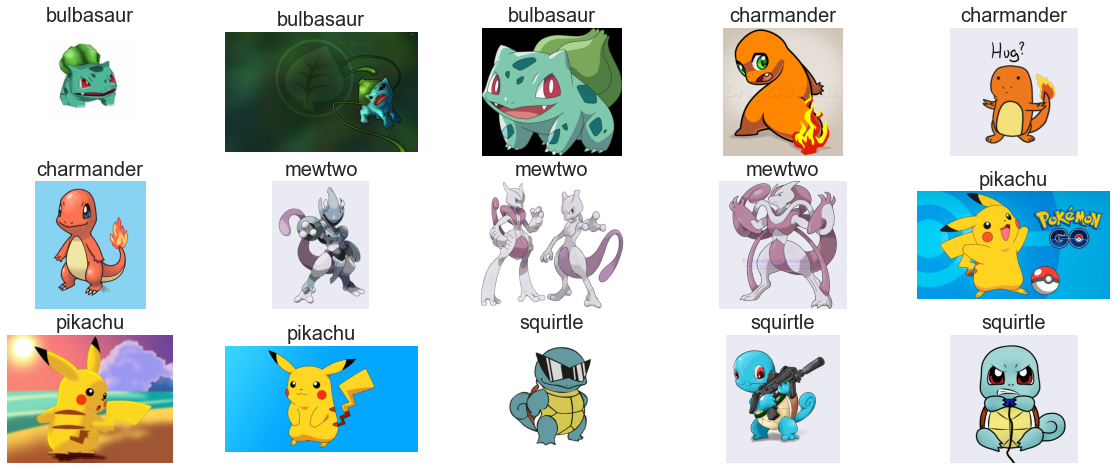

In [4]:
sample = list()
size = 3
i = 0
figure = plt.figure(figsize=(20,8))

for item in os.listdir('dataset/'):
  if item!='README':
    imagedir = os.path.join('dataset/',item)
    imageitem = os.listdir(imagedir)
    subset = np.random.choice(imageitem, 3, replace=False)
    
    for image_sample in subset:
      ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
      ax.set_title(imagedir.split('/')[1], fontsize=20)
      ax.imshow(img.imread( os.path.join(imagedir,image_sample),0 ))
      i+=1

### Generate training/evalaution dataset

In [5]:
IMG_SIZE_HEIGHT = 96
IMG_SIZE_WIDTH = 96

data_generator = image.ImageDataGenerator(rescale=1./255, validation_split=0.3)


train_generator = data_generator.flow_from_directory("./dataset",
                                                     shuffle=True,
                                                     target_size=(
                                                     IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH),
                                                     color_mode='rgb',
                                                     class_mode='categorical',
                                                     subset="training",
                                                     seed=1
                                                     )

validation_generator = data_generator.flow_from_directory("./dataset",
                                                          shuffle=True,
                                                          target_size=(
                                                          IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH),
                                                          color_mode='rgb',
                                                          class_mode='categorical',
                                                          subset="validation",
                                                          seed=1
                                                          )
                                                  


Found 820 images belonging to 5 classes.
Found 347 images belonging to 5 classes.


### Defines  the CNN model

## Task: In this section, we are going to define our CNN model

***Implement a CNN which consists of:***


1.   **Conv2D layer 1**
> filters=32, 
> kernel_size=(5,5), 
> strides=(1,1), 
> activation='relu', 
> input_shape=(IMG_SIZE_WIDTH, IMG_SIZE_HEIGHT, 3)
2.   **MaxPooling2D layer 1**
> pool_size=(5,5), 
> strides=(1,1)
3.   **Conv2D layer 2**
> filters=32, 
> kernel_size=(3,3), 
> strides=(1,1), 
> activation='relu'
4.   **MaxPooling2D layer 2**
> pool_size=(3,3),
> strides=(1,1)
5.   **Flatten layer**
6.   **Dense layer**
> units=100, activation='relu'
7.   **Output (Dense) layer**
> units=NUM_CLASSES, activation='softmax'




We used the softmax function to map the network's output scores into class probabilities:

$$ softmax(s_i) = \frac{\exp(s_i)}{\sum_{j=1}^K \exp(s_j)} $$

**Links to the documentation for your reference:**

Input layer:
https://www.tensorflow.org/api_docs/python/tf/keras/Input

Convolutional layer:
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

Pooling layer:
https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D


Flatten layer:
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten


Dense layer:
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense







In [6]:
clear_session()

NUM_CLASSES = 5

# building the CNN model

model = Sequential()

# Type your code here 
#===============================================================================
model.add(Conv2D(filters=32, kernel_size=(5,5), strides=1 , activation='relu', 
                     input_shape=(IMG_SIZE_WIDTH, IMG_SIZE_HEIGHT, 3))) 

model.add(MaxPool2D(pool_size=(5, 5), strides=1))

model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1 , activation='relu'))

model.add(MaxPool2D(pool_size=(3, 3), strides=1))

model.add(Flatten())

model.add(Dense(100, activation='relu'))

model.add(Dense(NUM_CLASSES, activation='softmax'))
#===============================================================================


model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])
    
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 92, 92, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 86, 86, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 84, 84, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 225792)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               22579300  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5

### Fitting the data into the model

In [7]:


es = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=1,restore_best_weights=True)


NUM_EPOCHS = 300


# Fitting the data into the model
result = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=NUM_EPOCHS,
    callbacks=[es],
)



Epoch 1/300
18/26 [===================>..........] - ETA: 4s - loss: 1.6984 - accuracy: 0.3872

C:\Users\johne\anaconda3\envs\coin\lib\site-packages\PIL\Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


26/26 [==============================] - 25s 849ms/step - loss: 1.4838 - accuracy: 0.4756 - val_loss: 0.7136 - val_accuracy: 0.7925
Epoch 2/300
26/26 [==============================] - 22s 835ms/step - loss: 0.6208 - accuracy: 0.7976 - val_loss: 0.5039 - val_accuracy: 0.8098
Epoch 3/300
26/26 [==============================] - 21s 828ms/step - loss: 0.4857 - accuracy: 0.8524 - val_loss: 0.3350 - val_accuracy: 0.9135
Epoch 4/300
26/26 [==============================] - 22s 840ms/step - loss: 0.3510 - accuracy: 0.8951 - val_loss: 0.4241 - val_accuracy: 0.8444
Epoch 5/300
26/26 [==============================] - 21s 835ms/step - loss: 0.2814 - accuracy: 0.9134 - val_loss: 0.3376 - val_accuracy: 0.8818
Restoring model weights from the end of the best epoch.
Epoch 00005: early stopping


<AxesSubplot:>

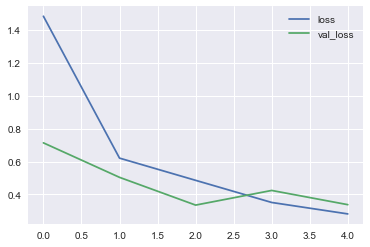

In [8]:
pd.DataFrame(result.history)[['loss','val_loss']].plot()

<AxesSubplot:>

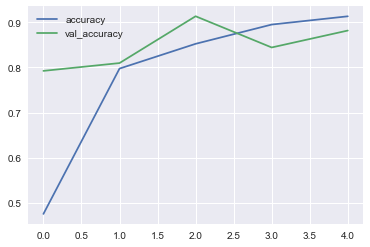

In [9]:
pd.DataFrame(result.history)[['accuracy','val_accuracy']].plot()

In [ ]:
filename = 'model.hdf5'


#model.save(filename)
#model = load_model(filename)

In [10]:
res = model.evaluate(validation_generator)
names = model.metrics_names
for i in range(len(res)):
  print(f'{names[i]}: {res[i]}')

C:\Users\johne\anaconda3\envs\coin\lib\site-packages\PIL\Image.py:974: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


11/11 [==============================] - 6s 554ms/step - loss: 0.3350 - accuracy: 0.9135
loss: 0.3349800109863281
accuracy: 0.9135446548461914


In [ ]:
#files.download('model.hdf5')

## Making Prediction

In [ ]:
if not LOCAL:
  # Create folder for file upload
  if not os.path.exists('./data/unknown'):
      os.makedirs('./data/unknown')
  else:
      shutil.rmtree('./data/unknown')
      os.makedirs('./data/unknown')

  uploaded = files.upload()

  for file_name in uploaded:
  # file_name = list(uploaded)[0]
  # print(file_name)
    shutil.move(file_name, os.path.join('./data/unknown', file_name))

    directory_path =  "./data"
else:
    directory_path =  "./test_data"



In [ ]:
predict_datagen = image.ImageDataGenerator(rescale=1./255)
predict_generator =  predict_datagen.flow_from_directory(
        directory_path,
        target_size=(IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH),
        color_mode="rgb",
        class_mode='categorical',
        batch_size=1)

filenames = predict_generator.filenames
predictions = model.predict(predict_generator)



prediction = np.argmax(predictions, axis=1)

label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items())
prediction = [label_map[k] for k in prediction]

filenames_predictions_map = list(zip(filenames, prediction))
print (filenames_predictions_map)

In [ ]:
figure = plt.figure(figsize=(25,10))
for i, (filename, pred_class) in enumerate(filenames_predictions_map):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])

   
    ax.set_title("{} ({:.2f}%) ({})".format(
                                  prediction[i], 
                                  np.max(predictions[i])*100,
                                  filename),
                 
                )
    ax.imshow(img.imread(os.path.join('./data/',filename)))
                                  
